In [1]:
import numpy as np
import pandas as pd
import fitsio
import os
import glob
import matplotlib.pyplot as plt

In [2]:
def list_nights_in_release(release_path='/global/cfs/cdirs/desi/spectro/redux/iron/exposures/', min_night=20210415):
    dirs = glob.glob(release_path+'/*')
    dirs.sort()
    nights = []
    for d in dirs:
        night = int(d.split('/')[-1])
        if night >= min_night:
            nights.append(night)
    return nights    

In [3]:
nights = list_nights_in_release()
print(nights, len(nights))

[20210415, 20210416, 20210417, 20210418, 20210419, 20210420, 20210422, 20210424, 20210425, 20210428, 20210429, 20210430, 20210501, 20210502, 20210503, 20210504, 20210505, 20210506, 20210507, 20210508, 20210509, 20210510, 20210511, 20210512, 20210513, 20210514, 20210515, 20210516, 20210517, 20210518, 20210519, 20210521, 20210522, 20210523, 20210528, 20210529, 20210530, 20210531, 20210601, 20210602, 20210603, 20210604, 20210605, 20210606, 20210607, 20210608, 20210609, 20210610, 20210611, 20210612, 20210613, 20210614, 20210615, 20210616, 20210617, 20210618, 20210619, 20210620, 20210621, 20210626, 20210627, 20210628, 20210629, 20210704, 20210705, 20210706, 20210707, 20210708, 20210709, 20210917, 20210919, 20210921, 20210923, 20210924, 20210926, 20210927, 20210928, 20210930, 20211001, 20211002, 20211003, 20211005, 20211006, 20211007, 20211008, 20211009, 20211010, 20211013, 20211014, 20211015, 20211016, 20211019, 20211020, 20211021, 20211022, 20211023, 20211024, 20211025, 20211026, 20211027,

In [4]:
def list_exps(date):
    exps_daily = pd.read_csv("/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.csv")
    #print(exps_daily.keys())
    ii = (exps_daily["NIGHT"]==date)
    #print(exps_daily["NIGHT"][ii])
    exps_daily = exps_daily[ii]
    return exps_daily

In [5]:
def read_sky_sframe(sframe_file):
    #print(sframe_file)
    try:
        h = fitsio.FITS(sframe_file)
        sel = h["FIBERMAP"]["OBJTYPE"].read() == "SKY"
        sky = h["FLUX"].read()[sel,:]
    except:
        sky = None
    return sky

In [6]:
def compute_sframe_difference(data_release_path, daily_path, date, expid, output_path="./data/"):
    filename = 'sky_diff_sframe_{}_{:08d}.csv'.format(date, expid)
    out_filename = os.path.join(output_path, filename)
    n_petals = 10
    bands = ['b', 'r', 'z']
    summary = {}
    summary['band'] = []
    summary['petal'] = []
    summary['diff_mean'] = []
    summary['diff_std'] = []
    summary['expid'] = []
    summary['night'] = []
    for i in range(n_petals):
        for band in bands:
            filename_A = '{}/{}/{:08d}/sframe-{}{}-{:08d}.fits'.format(data_release_path, date, expid, band, i, expid)
            sky_petal_A = read_sky_sframe(filename_A)
            filename_B = '{}/{}/{:08d}/sframe-{}{}-{:08d}.fits'.format(daily_path, date, expid, band, i, expid)
            sky_petal_B = read_sky_sframe(filename_B)
            if sky_petal_A is not None and sky_petal_B is not None:
                sky_diff = sky_petal_B-sky_petal_A
           #     proba = ient.compute_probability_distribution_2D(sky_petal)
           #     entropy =  ient.compute_entropy(proba)
                summary['band'].append(band)
                summary['petal'].append(i)
                summary['diff_mean'].append(sky_diff.mean())
                summary['diff_std'].append(sky_diff.std())
                summary['expid'].append(expid)
                summary['night'].append(date)
                #print(date, expid, band, i, sky_diff.mean(), sky_diff.std())
    entropy_df = pd.DataFrame.from_dict(summary)

    #os.makedirs(output_path, exist_ok=True) 
    entropy_df.to_csv(out_filename)
    
    #print(summary)

In [7]:
def data_comparison_release_vs_daily(data_release_path, daily_path, date, output_path="./data"):
    exps = list_exps(date)
    # compute differences
    dates = list(exps["NIGHT"])
    expids = list(exps["EXPID"])
    for date, expid in zip(dates, expids):
        compute_sframe_difference(data_release_path, daily_path, date, expid, output_path=output_path)

In [8]:
iron_path = '/global/cfs/cdirs/desi/spectro/redux/iron/exposures/'
daily_path = '/global/cfs/cdirs/desi/spectro/redux/daily/exposures/'

In [ ]:
#date = 20220430
#data_comparison_release_vs_daily(iron_path, daily_path, date)

In [ ]:
#date = 20210606
#data_comparison_release_vs_daily(iron_path, daily_path, date)

In [ ]:
#date = 20211111
#data_comparison_release_vs_daily(iron_path, daily_path, date)

In [9]:
#plot 
def plot_differences(date, data_path="../data/"):
    plt.figure(figsize=(10,3))
    diff_files = glob.glob(os.path.join(data_path, 'sky_diff_sframe_{}_*'.format(date)))
    
    mean = []
    std = []
    for diff_file in diff_files:
        sky_diff = pd.read_csv(diff_file)
        mean = mean+list(sky_diff['diff_mean'])
        std = std+list(sky_diff['diff_std'])
    mean = np.array(mean)
    std = np.array(std)
    
    outlier = (np.abs(mean)>4.0) & (std>2E3)
    n_outlier = np.count_nonzero(outlier)
    n_total = len(mean)
    
    plt.subplot(1,3,1)
    plt.semilogy()
    plt.scatter(mean, std, color='black', alpha=0.4)
    #plt.title('sky sframe differences (Daily - Iron). night {}'.format(date))
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.xlim(-5,5)
    plt.ylim(1,10000)
    
    plt.subplot(1,3,2)
    plt.hist(mean, bins=np.linspace(-5,5), log=True)
    A = 'sky sframe differences (Daily - Iron).\n'
    B = 'Each point is a different (petal,camera,exposure) combination.\n'
    plt.title( A+B+'Night {}. % outliers: {:.2f}'.format(date, 100*n_outlier/n_total))
    plt.xlabel('Mean')
    plt.ylabel('Counts')
    plt.xlim(-5,5)

    
    plt.subplot(1,3,3)
    plt.hist(np.log10(std), bins=np.linspace(0,4), log=True)
    #plt.title('sky sframe differences (Daily - Iron). night {}'.format(date))
    plt.xlabel('log$_{10}$ std')
    plt.ylabel('Counts')
    plt.xlim(0,4)
    plt.tight_layout()
    plt.savefig('ssframe_diff_daily-iron_{}.jpg'.format(date))
    return mean, std

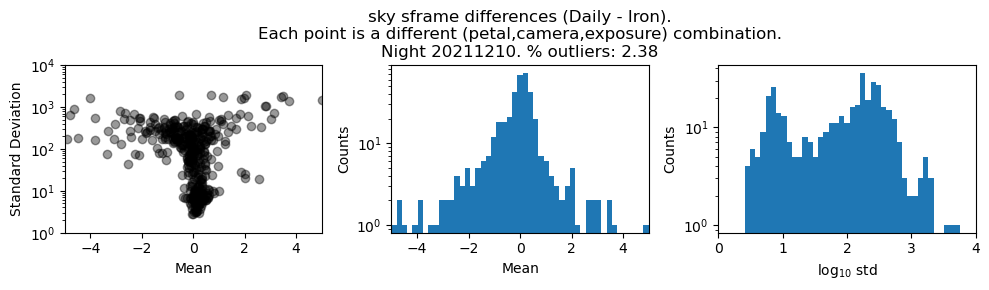

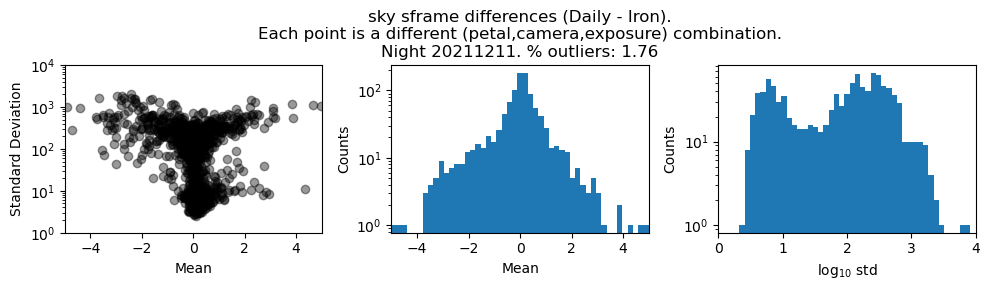

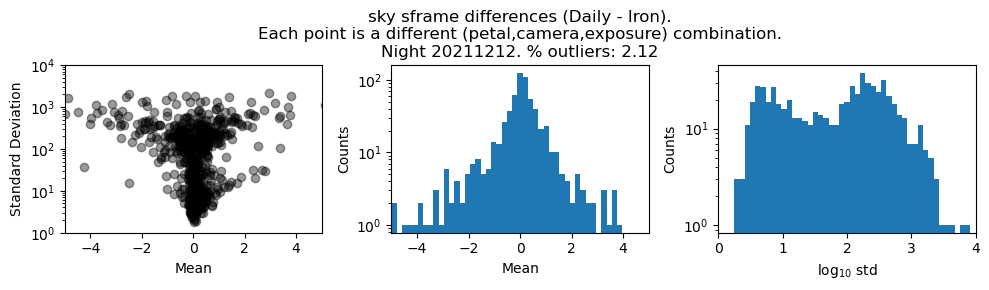

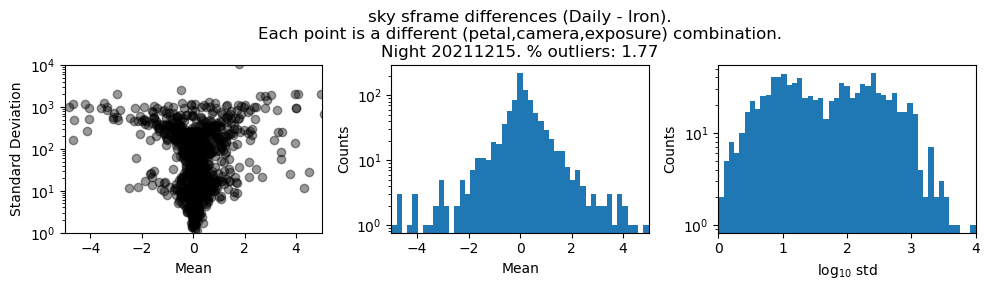

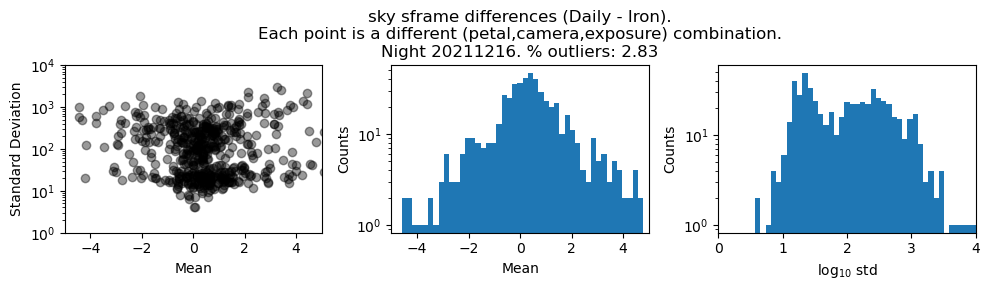

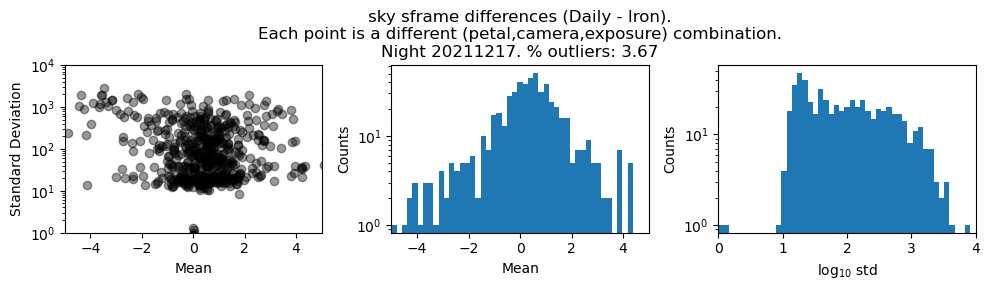

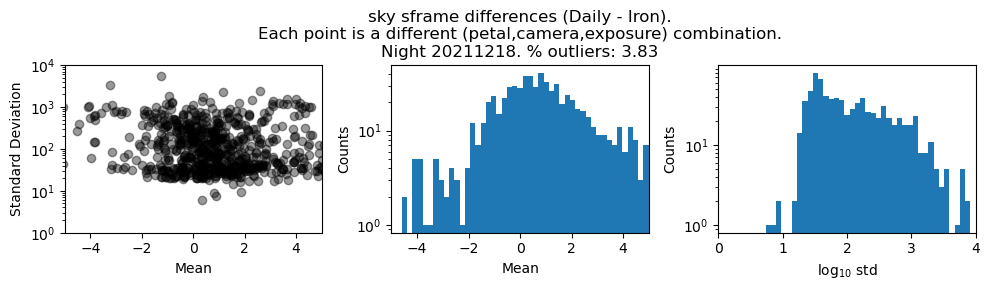

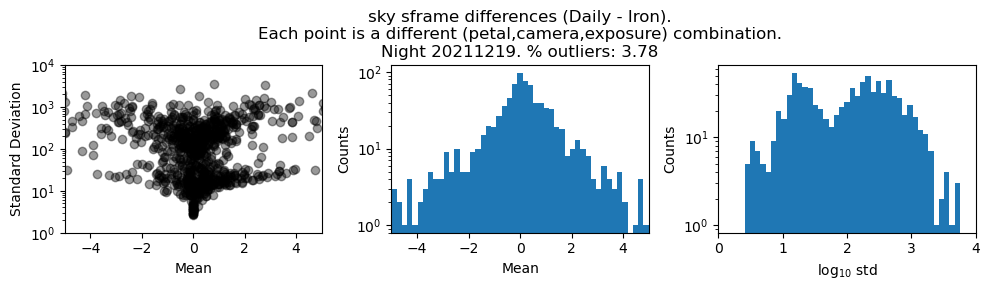

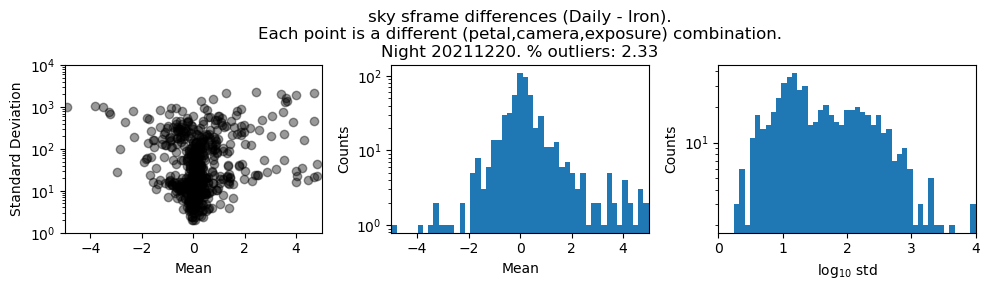

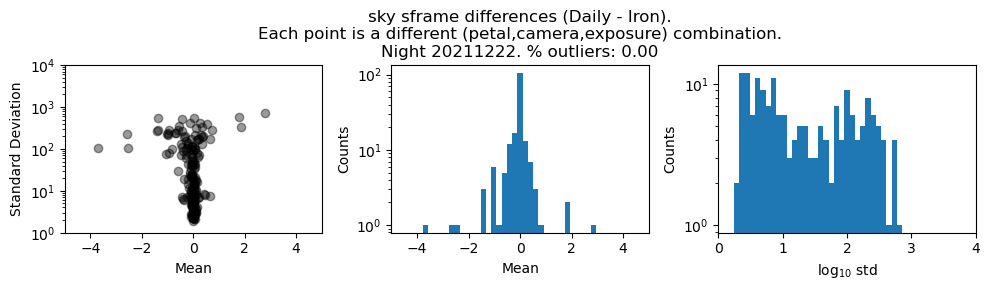

In [13]:
for date in nights[140:150]:
    a = plot_differences(date)

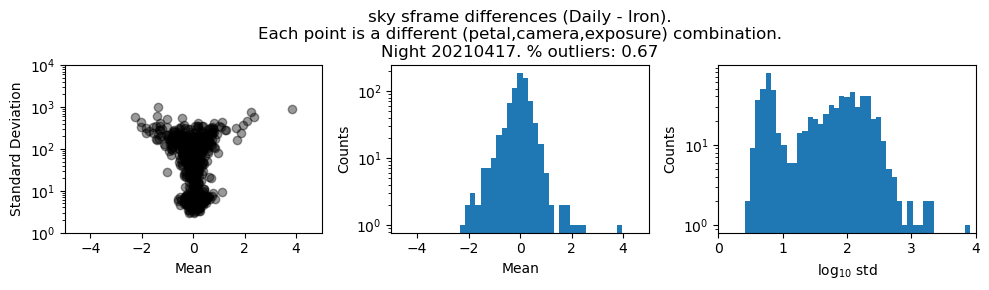

In [87]:
a = plot_differences(20210417)

ZeroDivisionError: division by zero

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


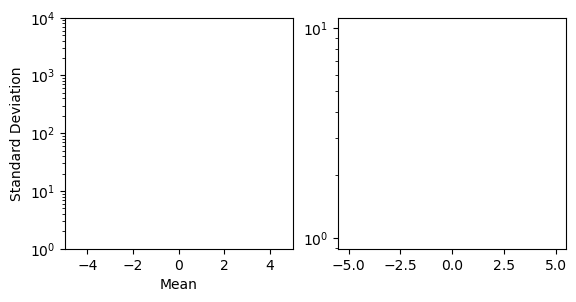

In [88]:
a = plot_differences(20210418)

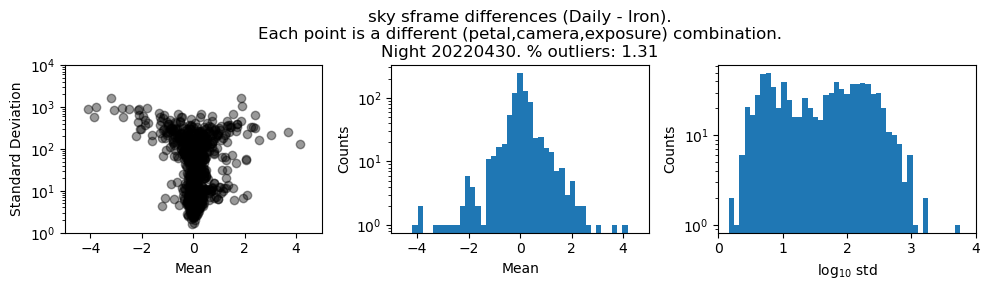

In [82]:
a = plot_differences(20220430, data_path="./")

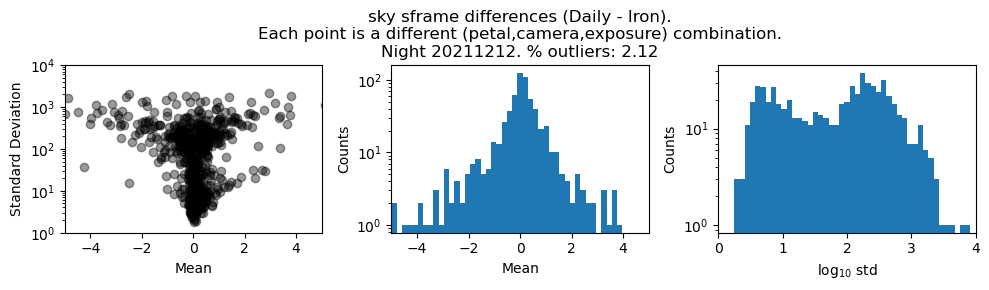

In [78]:
a = plot_differences(20211212, data_path="./")

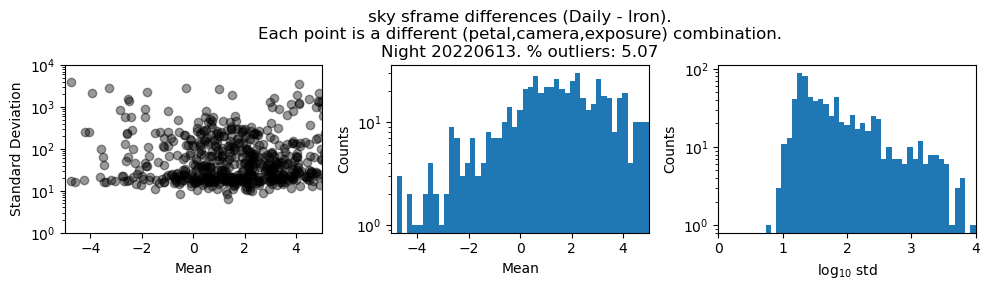

In [79]:
a = plot_differences(20220613, data_path="./")

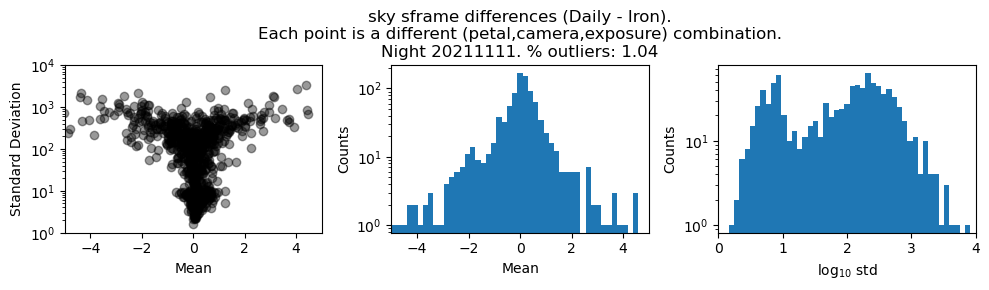

In [73]:
a = plot_differences(20211111, data_path="./")

In [ ]:
#plot 
def print_outliers(date):
    plt.figure(figsize=(10,3))
    diff_files = glob.glob('sky_diff_sframe_{}_*'.format(date))
    
    mean = []
    std = []
    for diff_file in diff_files:
        sky_diff = pd.read_csv(diff_file)
        ii = (np.abs(sky_diff['diff_mean'])>2.0) & (sky_diff['diff_std']>1000.0)
        if np.count_nonzero(ii):
            print(diff_file)
            print(sky_diff[ii])
 

In [ ]:
print_outliers(20211212)